# Clustering II
## K-Means & Gaussian Mixture Model (GMM)

Instalamos Spark


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

In [2]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/11/02 23:22:20 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In this Colab, rather than downloading a file from Google Drive, we will load a famous machine learning dataset, the [Breast Cancer Wisconsin dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html), using the ```scikit-learn``` datasets loader.

In [3]:
from sklearn.datasets import load_breast_cancer
breast_cancer = load_breast_cancer()

For convenience, given that the dataset is small, we first 

*   construct a Pandas dataframe
*   tune the schema
*   and convert it into a Spark dataframe.

In [4]:
pd_df = pd.DataFrame(breast_cancer.data, columns=breast_cancer.feature_names)
df = spark.createDataFrame(pd_df)

def set_df_columns_nullable(spark, df, column_list, nullable=False):
    for struct_field in df.schema:
        if struct_field.name in column_list:
            struct_field.nullable = nullable
    df_mod = spark.createDataFrame(df.rdd, df.schema)
    return df_mod

df = set_df_columns_nullable(spark, df, df.columns)
df = df.withColumn('features', array(df.columns))
vectors = df.rdd.map(lambda row: Vectors.dense(row.features))

df.printSchema()

root
 |-- mean radius: double (nullable = false)
 |-- mean texture: double (nullable = false)
 |-- mean perimeter: double (nullable = false)
 |-- mean area: double (nullable = false)
 |-- mean smoothness: double (nullable = false)
 |-- mean compactness: double (nullable = false)
 |-- mean concavity: double (nullable = false)
 |-- mean concave points: double (nullable = false)
 |-- mean symmetry: double (nullable = false)
 |-- mean fractal dimension: double (nullable = false)
 |-- radius error: double (nullable = false)
 |-- texture error: double (nullable = false)
 |-- perimeter error: double (nullable = false)
 |-- area error: double (nullable = false)
 |-- smoothness error: double (nullable = false)
 |-- compactness error: double (nullable = false)
 |-- concavity error: double (nullable = false)
 |-- concave points error: double (nullable = false)
 |-- symmetry error: double (nullable = false)
 |-- fractal dimension error: double (nullable = false)
 |-- worst radius: double (nullable

With the next cell, we build the two data structures that we will be using throughout this Colab:


*   ```features```, a dataframe of Dense vectors, containing all the original features in the dataset;
*   ```labels```, a series of binary labels indicating if the corresponding set of features belongs to a subject with breast cancer, or not.



In [5]:
from pyspark.ml.linalg import Vectors
features = spark.createDataFrame(vectors.map(Row), ["features"])
labels = pd.Series(breast_cancer.target)

Información sobre el algoritmo básico de [K-means](https://spark.apache.org/docs/latest/ml-clustering.html) incluído en MLlib.

Calculamos dos funciones para determinar el número de clusters.  El WCSS y el 
 [Silhouette score](https://es.wikipedia.org/wiki/Silhouette_(clustering)) 

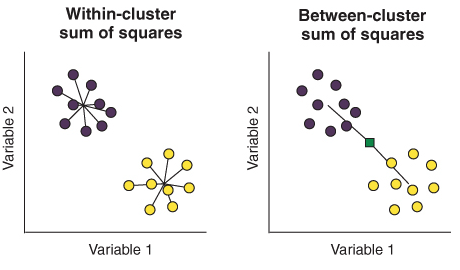

Más información sobre la silueta:  https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

In [6]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [7]:
rango = range(2,16)
evaluator = ClusteringEvaluator()

In [8]:
cost = []
silhouette = []

for k in rango:
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(features)
    preds = model.transform(features)
    cost.append(model.summary.trainingCost)
    silhouette.append(evaluator.evaluate(preds))

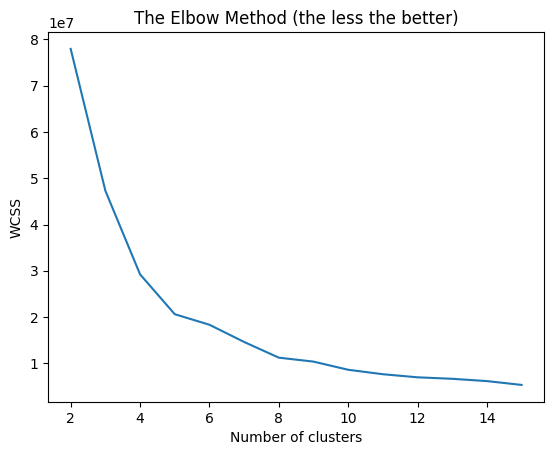

In [9]:
plt.plot(rango, cost)
plt.title('The Elbow Method (the less the better)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

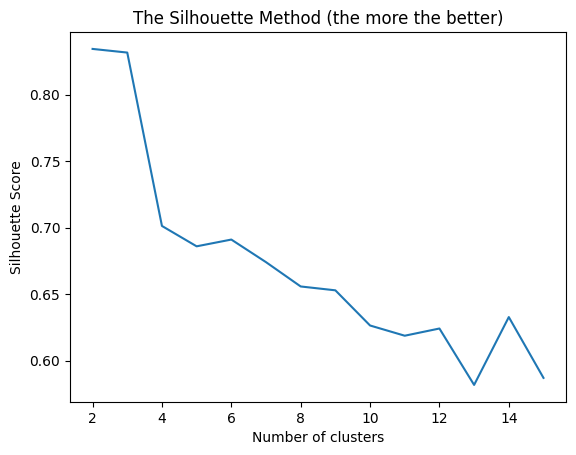

In [10]:
plt.plot(rango, silhouette)
plt.title('The Silhouette Method (the more the better)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [11]:
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(features)
preds = model.transform(features)

In [12]:
predictions = preds.toPandas()['prediction']

In [13]:
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score

In [14]:
ARI = adjusted_rand_score(labels,predictions)

In [15]:
AMI = adjusted_mutual_info_score(labels,predictions)

In [16]:
ARI

0.49142453622455523

Replicar los resultados de k-means para bisecting k-means y GMM:  https://spark.apache.org/docs/latest/ml-clustering.html y discutir los resultados.

# Bisecting K-means

In [17]:
from pyspark.ml.clustering import BisectingKMeans

In [18]:
cost = []
silhouette = []

for k in rango:
    bkmeans = BisectingKMeans().setK(k).setSeed(1)
    model = bkmeans.fit(features)
    preds = model.transform(features)
    cost.append(model.summary.trainingCost)
    silhouette.append(evaluator.evaluate(preds))

# ...


Aplicar Latent Dirichlet Allocation (LDA) https://spark.apache.org/docs/latest/ml-clustering.html para encontrar temas en un corpus de texto.


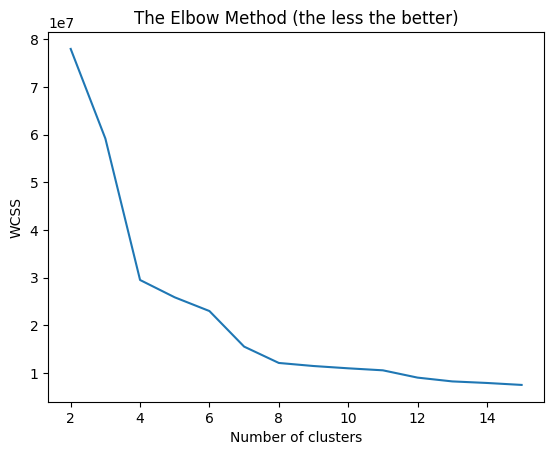

In [19]:
plt.plot(rango, cost)
plt.title('The Elbow Method (the less the better)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

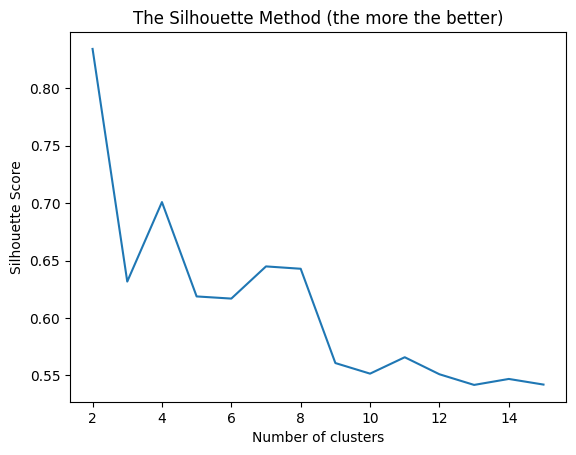

In [20]:
plt.plot(rango, silhouette)
plt.title('The Silhouette Method (the more the better)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [21]:
kmeans = BisectingKMeans().setK(2).setSeed(1)
model = bkmeans.fit(features)
preds = model.transform(features)

In [22]:
predictions = preds.toPandas()['prediction']

In [23]:
ARI = adjusted_rand_score(labels,predictions)

In [24]:
AMI = adjusted_mutual_info_score(labels,predictions)

In [25]:
ARI

0.12227192859344027

# Gaussian Mixture Modelo (GMM)

In [44]:
from pyspark.ml.clustering import GaussianMixture

In [48]:
cost = []
silhouette = []

for k in rango:
    gmm = GaussianMixture().setK(k).setSeed(1)
    model = gmm.fit(features)
    preds = model.transform(features)
    cost.append(model.summary.trainingCost)
    silhouette.append(evaluator.evaluate(preds))

AttributeError: 'GaussianMixtureSummary' object has no attribute 'trainingCost'

ValueError: x and y must have same first dimension, but have shapes (14,) and (0,)

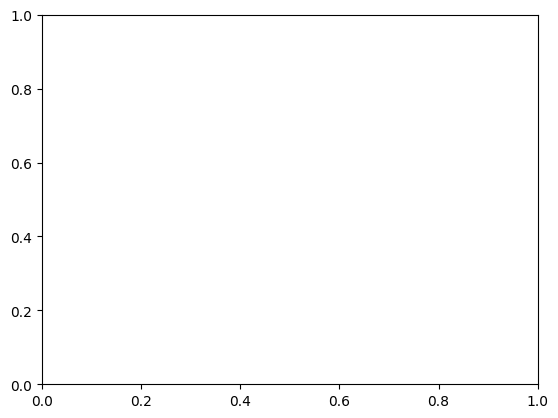

In [47]:
plt.plot(rango, cost)
plt.title('The Elbow Method (the less the better)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()